In [1]:
#import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Rescaling
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory

In [2]:
physical_devices = tf.config.list_physical_devices()
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [3]:
batch_size=16
image_size=(250, 250)

In [4]:
train_ds = image_dataset_from_directory(
    'Rice_Image_Dataset',
    color_mode='grayscale',
    shuffle = True,
    subset='training',
    validation_split=0.2,
    seed=42,                 
    batch_size=batch_size,
    image_size=image_size
)

test_ds = image_dataset_from_directory(
    'Rice_Image_Dataset',
    color_mode='grayscale',
    shuffle = True,
    subset='validation',
    validation_split=0.2,
    seed=42,                 
    batch_size=batch_size,
    image_size=image_size
)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


TypeError: 'BatchDataset' object is not subscriptable

In [6]:
class_names = train_ds.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

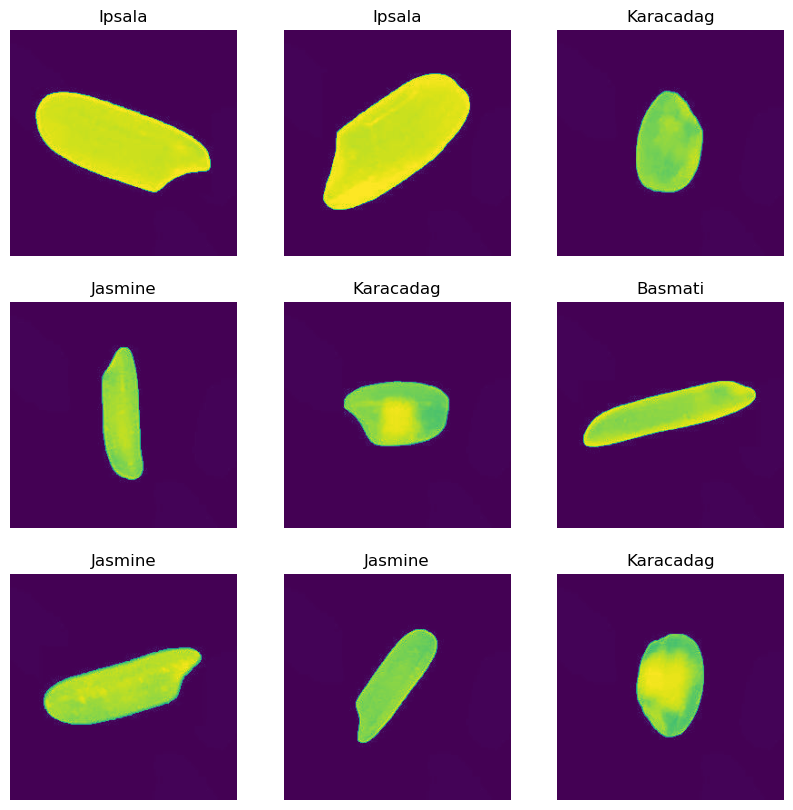

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)

model = Sequential([
  Rescaling(1./255, input_shape=(image_size[0],image_size[1], 1)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D((2, 2), strides=2),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D((2, 2), strides=2),
  Flatten(),
  Dense(32, activation='relu'),
  Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 250, 250, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 250, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                3

In [10]:
model.compile(
    optimizer=adam_v2.Adam(learning_rate=0.01),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    patience=8,
    monitor='val_accuracy',
    min_delta=1e-4,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint(
    'models/Rice-CNN.hdf5',
    monitor='val_accuracy',
    save_best_only=True
)

In [11]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  steps_per_epoch=75,
  callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
75/75 [==============================] - 219s 3s/step - loss: 1.6647 - accuracy: 0.6250 - val_loss: 0.3975 - val_accuracy: 0.8743
Epoch 2/50
75/75 [==============================] - 154s 2s/step - loss: 0.3347 - accuracy: 0.8992 - val_loss: 0.4573 - val_accuracy: 0.8368
Epoch 3/50
75/75 [==============================] - 140s 2s/step - loss: 0.3415 - accuracy: 0.8808 - val_loss: 0.2857 - val_accuracy: 0.9064
Epoch 4/50
75/75 [==============================] - 125s 2s/step - loss: 0.2506 - accuracy: 0.9125 - val_loss: 0.2621 - val_accuracy: 0.9142
Epoch 5/50
75/75 [==============================] - 129s 2s/step - loss: 0.2686 - accuracy: 0.9108 - val_loss: 0.2324 - val_accuracy: 0.9195
Epoch 6/50
75/75 [==============================] - 134s 2s/step - loss: 0.2289 - accuracy: 0.9300 - val_loss: 0.2550 - val_accuracy: 0.9173
Epoch 7/50
75/75 [==============================] - 133s 2s/step - loss: 0.2141 - accuracy: 0.9350 - val_loss: 0.1690 - val_accuracy: 0.9449
Epoch 8/50
75

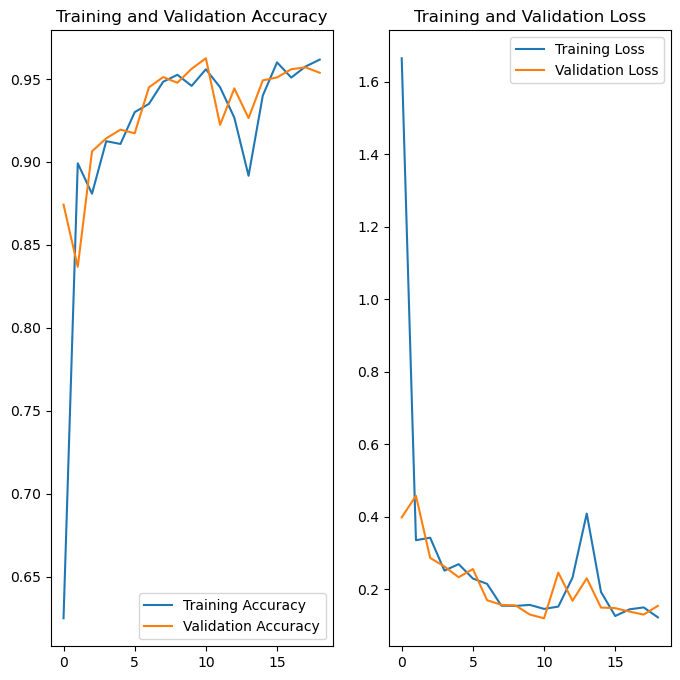

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()